<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/FeatureSelection/EmbeddedMethods/3_2_Basic_filter_methods_and_Lasso_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Filter Methods plus LASSO pipeline
### Putting it all together

In [4]:
!pip install --user kaggle
!mkdir .kaggle
import json
token = {"username":"vinay10949","key":"59c4901452f76ce62979e5b0997e240b"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
#kaggle competitions download -c santander-customer-satisfaction

mkdir: cannot create directory ‘.kaggle’: File exists


In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c santander-customer-satisfaction
!unzip train.csv.zip


  0% 0.00/4.05M [00:00<?, ?B/s]
100% 4.05M/4.05M [00:00<00:00, 66.0MB/s]
  0% 0.00/4.02M [00:00<?, ?B/s]
100% 4.02M/4.02M [00:00<00:00, 36.9MB/s]
  0% 0.00/612k [00:00<?, ?B/s]
100% 612k/612k [00:00<00:00, 84.5MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [8]:
# load the Santander customer satisfaction dataset from Kaggle

data = pd.read_csv('train.csv')
data.shape

(76020, 371)

In [9]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 370), (22806, 370))

In [0]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [11]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 332), (22806, 332))

### Remove quasi-constant features

In [12]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

268

In [0]:
features_to_keep = X_train.columns[sel.get_support()]

In [14]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((53214, 268), (22806, 268))

In [0]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features

In [16]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


16

In [0]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

In [0]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Remove correlated features

In [19]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  133


In [20]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 119), (22806, 119))

In [0]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Remove features using univariate ROC-AUC

In [0]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

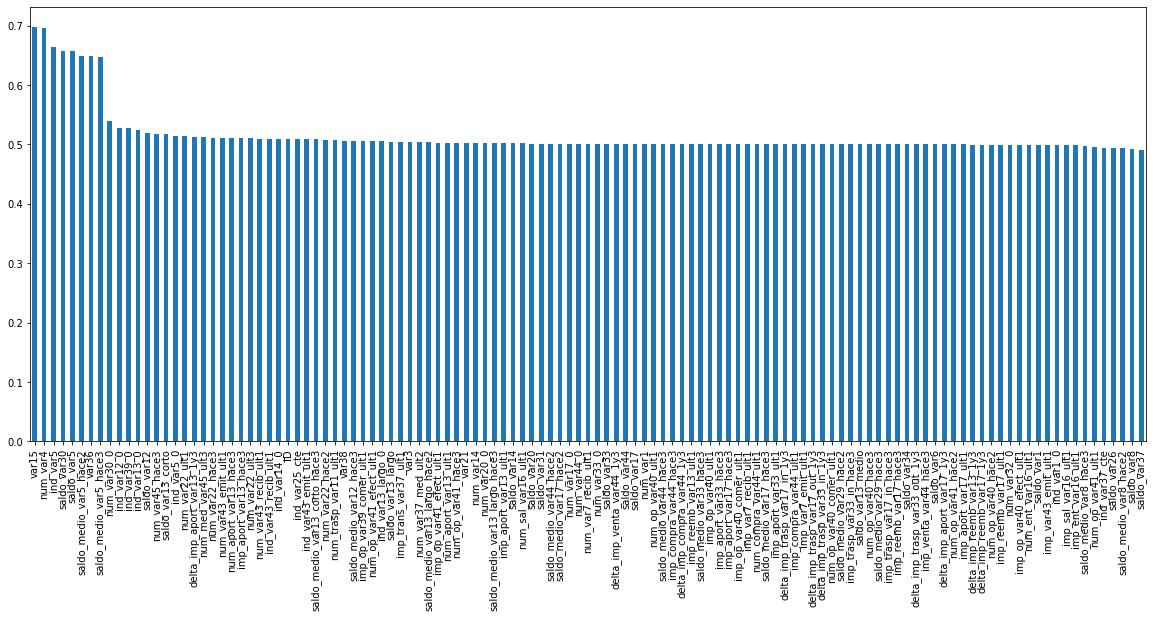

In [26]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [27]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features

selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(90, 119)

### Remove features using Lasso

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [31]:
# fit a lasso and selet features, make sure to select l1
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(X_train), y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
X_train_lasso.shape, X_test_lasso.shape
X_train_lasso.columns

Index(['var15', 'ind_var5', 'ind_var12_0', 'ind_var13_0', 'num_var4',
       'num_var20_0', 'num_op_var40_hace2', 'num_op_var40_ult1', 'num_var30_0',
       'num_var33_0', 'num_var44_0', 'saldo_var5', 'saldo_var8', 'saldo_var12',
       'saldo_var13_corto', 'saldo_var13_largo', 'saldo_var30', 'var36',
       'delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3',
       'delta_imp_venta_var44_1y3', 'imp_aport_var13_ult1',
       'imp_var7_recib_ult1', 'imp_reemb_var13_ult1', 'imp_var43_emit_ult1',
       'num_aport_var13_hace3', 'num_aport_var13_ult1',
       'num_compra_var44_ult1', 'num_op_var40_comer_ult1',
       'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3',
       'saldo_medio_var8_hace2', 'saldo_medio_var12_hace3',
       'saldo_medio_var13_largo_hace2', 'saldo_medio_var17_hace2', 'var38'],
      dtype='object')

### Compare the performance in machine learning algorithms

In [0]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [35]:
# original
run_randomForests(X_train_original.drop(labels=['ID'], axis=1),
                  X_test_original.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8012314741948454
Test set
Random Forests roc-auc: 0.7900499757912425


In [36]:
# filter methods - basic
run_randomForests(X_train_basic_filter.drop(labels=['ID'], axis=1),
                  X_test_basic_filter.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8016577097093865
Test set
Random Forests roc-auc: 0.791033019265853


In [37]:
# filter methods - correlation
run_randomForests(X_train_corr.drop(labels=['ID'], axis=1),
                  X_test_corr.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8073914001626228
Test set
Random Forests roc-auc: 0.7937667747098247


In [38]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],
                  X_test_corr[selected_feat.index],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8105671870819526
Test set
Random Forests roc-auc: 0.7985492537265694


In [43]:
# embedded methods - Lasso
#run_randomForests(X_train_lasso.drop(labels=['ID'], axis=1),
#                  X_test_lasso.drop(labels=['ID'], axis=1),
#                  y_train, y_test)

run_randomForests(X_train_lasso,X_test_lasso,y_train, y_test)

Train set
Random Forests roc-auc: 0.8130322934369456
Test set
Random Forests roc-auc: 0.7998181144676413


Selecting features using Lasso or univariate feature selection using the roc-auc lead to very similar results:

univariate: 0.7985

Lasso: 0.7981

The difference is in the 4th decimal, which is likely within the error (remember that all models have an error, which you could estimate doing cross-validation).

Therefore, for this dataset, any of the 2 approaches would lead to a similar result in terms of performance and final number of features used (90 and 91 respectively).

Let's have a look at the performance of logistic regression.

In [0]:
# create a function to build logistic regression and compare performance in train and test set

def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [45]:
# original
scaler = StandardScaler().fit(X_train_original.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_original.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_original.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8068058302056849
Test set
Logistic Regression roc-auc: 0.7948755847784289


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_basic_filter.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_basic_filter.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8057705860547986
Test set
Logistic Regression roc-auc: 0.7951899887692155


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_corr.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_corr.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7966160581765025
Test set
Logistic Regression roc-auc: 0.7931114290523482


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])

run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7930112658867351
Test set
Logistic Regression roc-auc: 0.794774206858335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [50]:
# embedded methods - Lasso
run_randomForests(X_train_lasso,X_test_lasso,y_train, y_test)

Train set
Random Forests roc-auc: 0.8130322934369456
Test set
Random Forests roc-auc: 0.7998181144676413


For logistic regression, Lasso provides a better selection of features:

univariate: 0.7946

Lasso: 0.7981

In fact, Lasso feature selection renders the same performance for both random forests and logistic regressions, whereas the univariate roc-auc selects a subset of features that produces a less performing logistic regression model. So if your final model is a logistic regression for its simplicity and interpretability, the features selected by Lasso are the ones to be used.

This is not surprising, because Lasso is a regularisation for linear models. Then, it is expected that the feature space selected is the optimal for a linear algorithm.

Having said this, 90 features are still a lot of features, so stay tuned in the course to see if we can reduce this further.

That is all for this lecture. I hope you enjoyed it!